In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time
import os

# --- 1. CONFIGURACIÓN INICIAL PARA AMAZON ---
TERMINO_BUSQUEDA = "computadores"
URL_INICIAL = f"https://www.amazon.com/s?k={TERMINO_BUSQUEDA}" 
NUMERO_DE_PAGINAS = 5 # Extracción de 5 páginas

# Headers avanzados para simular un navegador genuino
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Referer': 'https://www.amazon.com/', 
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'es-ES,es;q=0.9',
    'Cookie': 'custom_cookie=true',
    'Connection': 'keep-alive',
}

# --- Función Auxiliar para Limpieza de Precios (FINAL Y ROBUSTA) ---
def limpiar_precio(precio_str):
    """Limpia el string de precio, elimina símbolos, comas, y garantiza formato float para el cálculo."""
    if isinstance(precio_str, str):
        # 1. Eliminar caracteres no deseados y texto de referencia
        precio_limpio = precio_str.replace('\u00a0', ' ').replace('USD', '').replace('PEN', '').replace('S/', '').replace('$', '').replace('PVPR:', '').replace('Lista:', '').strip()
        
        # 2. Manejar separadores: Eliminar comas (separadores de miles)
        precio_limpio = precio_limpio.replace(',', '') 
        
        # 3. Forzar formato de un solo punto decimal, eliminando puntos extras.
        if precio_limpio.count('.') > 1:
             partes = precio_limpio.rsplit('.', 1) 
             entero = partes[0].replace('.', '') 
             decimal = partes[1] if len(partes) > 1 else '00'
             precio_limpio = f"{entero}.{decimal}"
        
        # 4. Asegurar que no hay doble punto residual
        precio_limpio = precio_limpio.replace('..', '.')
        
        try:
            # 5. Intentar la conversión final a flotante
            return float(precio_limpio.strip())
        except ValueError:
            return None
    return None

# --- 2. FUNCIÓN DE SOLICITUD HTTP Y PARSEO ---
def obtener_contenido_pagina(url):
    """
    Realiza la solicitud HTTP GET y devuelve el objeto BeautifulSoup.
    """
    try:
        response = requests.get(url, headers=HEADERS, timeout=15)
        
        print(f"    - Código de estado HTTP recibido: {response.status_code}") 
        
        response.raise_for_status() 

        return BeautifulSoup(response.content, "html.parser")

    except requests.exceptions.RequestException as e:
        print(f"❌ Error al realizar la solicitud a {url}: {e}")
        return None

# --- 3. FUNCIÓN DE EXTRACCIÓN Y FILTRADO ESTRICTO ---
def extraer_datos_amazon_ofertas(soup):
    datos_productos = []
    # Selector principal
    contenedores_productos = soup.find_all('div', {'data-component-type': 's-search-result'})
    
    print(f"    -> Productos encontrados para extraer: {len(contenedores_productos)}")

    for contenedor in contenedores_productos:
        
        nombre = 'N/A'
        precio_antes = 'N/A'
        precio_despues = 'N/A'
        url_image = 'N/A'
        
        # --- Nombre del Producto ---
        titulo_h2 = contenedor.find('h2')
        if titulo_h2:
             span_titulo = titulo_h2.find('span')
             nombre = span_titulo.text.strip() if span_titulo else titulo_h2.text.strip()
        
        # --- Precio Actual (precio_despues) ---
        precio_span = contenedor.find('span', class_='a-price')
        if precio_span:
            p_entero = precio_span.find('span', class_='a-price-whole')
            p_fraccion = precio_span.find('span', class_='a-price-fraction')
            moneda = precio_span.find('span', class_='a-price-symbol')
            
            p_entero_str = p_entero.text.strip() if p_entero else ''
            p_fraccion_str = p_fraccion.text.strip() if p_fraccion else ''
            moneda_str = moneda.text.strip() if moneda else 'USD'
            
            if p_entero_str or p_fraccion_str:
                # Formato de salida del string, limpio de NBSP y dobles puntos
                precio_despues = f"{moneda_str} {p_entero_str}.{p_fraccion_str}".replace('\xa0', ' ').replace('..', '.') 

        # --- Precio Antes (precio_antes) ---
        precio_antes_tag = contenedor.find('span', class_='a-price', attrs={'data-a-strike': 'true'})
        
        if precio_antes_tag:
            offscreen_price = precio_antes_tag.find('span', class_='a-offscreen')
            if offscreen_price:
                precio_antes = offscreen_price.text.strip().replace('\u00a0', ' ')
            else:
                precio_antes = precio_antes_tag.text.strip().replace('\u00a0', ' ')
            
            # Limpieza de precio_antes para el string de salida
            precio_antes = precio_antes.replace('PVPR:', '').replace('Lista:', '').strip().replace('..', '.')
        
        # --- URL de la Imagen ---
        imagen_tag = contenedor.find('img', class_='s-image')
        url_image = imagen_tag.get('src') if imagen_tag and imagen_tag.get('src') else 'N/A'
        
        # --- Cálculo de Descuento ---
        descuento = '0%'
        
        # USAMOS LAS VERSIONES NUMÉRICAS LIMPIAS PARA EL CÁLCULO
        num_despues = limpiar_precio(precio_despues)
        num_antes = limpiar_precio(precio_antes) 
        
        if num_antes and num_despues and num_antes > num_despues:
            calc_descuento = ((num_antes - num_despues) / num_antes) * 100
            descuento = f"{calc_descuento:.0f}%" 
        
        # --- FILTRO ESTRICTO (FINAL) ---
        # Solo añadir si tiene NOMBRE, PRECIO ACTUAL, Y PRECIO ANTES (Oferta real)
        if nombre != 'N/A' and precio_despues != 'N/A' and precio_antes != 'N/A':
            datos_productos.append({
                "nombre": nombre.replace('\u00a0', ' '),
                "precio_antes": precio_antes.replace('\u00a0', ' '),
                "precio_despues": precio_despues.replace('\u00a0', ' '), 
                "descuento": descuento,
                "url_image": url_image
            })
        
    return datos_productos

# --- 4. ORQUESTACIÓN Y PAGINACIÓN DINÁMICA ---
def ejecutar_scraper_amazon_ofertas(url_inicial, num_paginas):
    """
    Función principal que maneja la paginación dinámica.
    """
    total_datos = []
    url_actual = url_inicial
    
    for pagina_actual in range(1, num_paginas + 1):
        if url_actual is None:
            print("⚠️ No se encontró el enlace a la página siguiente. Finalizando.")
            break
            
        print(f"\n📢 Procesando página {pagina_actual}/{num_paginas}. URL actual: {url_actual}")
        
        soup = obtener_contenido_pagina(url_actual)
        
        if soup is None:
            print("🛑 Error al obtener la página. Deteniendo el scraper.")
            break
            
        nuevos_datos = extraer_datos_amazon_ofertas(soup) 
        
        if not nuevos_datos and pagina_actual == 1:
             print("⚠️ ¡FALLO CRÍTICO! No se encontraron productos con oferta en la página 1.")
             break
        
        total_datos.extend(nuevos_datos)
        
        enlace_siguiente = soup.find('a', class_='s-pagination-next')

        if enlace_siguiente:
            url_actual = "https://www.amazon.com" + enlace_siguiente.get('href')
        else:
            url_actual = None 

        time.sleep(3) 

    return total_datos

# --- 5. EJECUCIÓN E IMPRESIÓN COMO LISTA DE DICCIONARIOS ---
if __name__ == "__main__":
    
    # Ejecutar el proceso de extracción
    resultados_finales_diccionario = ejecutar_scraper_amazon_ofertas(URL_INICIAL, NUMERO_DE_PAGINAS)
    
    if resultados_finales_diccionario:
        print(f"\n✅ Extracción de Amazon completada. Total de productos filtrados: {len(resultados_finales_diccionario)}.")
        
        # IMPRIMIR LA LISTA DE DICCIONARIOS (Formato profesional)
        print("\n--- SALIDA FINAL: LISTA DE DICCIONARIOS (Muestra de Ofertas Reales) ---")
        
        if len(resultados_finales_diccionario) > 0:
            # Imprimir una muestra para no saturar la salida
            print(json.dumps(resultados_finales_diccionario[:5], indent=4))
            print(f"\n... Se omiten {len(resultados_finales_diccionario) - 5} productos más para la vista previa. Total: {len(resultados_finales_diccionario)}.")
        
        # PARA EL TRABAJO COLABORATIVO: GUARDAR EN CSV
        df = pd.DataFrame(resultados_finales_diccionario)
        if not os.path.exists('data'): os.makedirs('data')
        df.to_csv('data/amazon_ofertas_filtradas.csv', index=False, encoding='utf-8')
        print("\n💾 Datos guardados en CSV: data/amazon_ofertas_filtradas.csv")
        
    else:
        print("\n⚠️ La extracción de Amazon no produjo resultados con los filtros aplicados.")


📢 Procesando página 1/5. URL actual: https://www.amazon.com/s?k=computadores
❌ Error al realizar la solicitud a https://www.amazon.com/s?k=computadores: HTTPSConnectionPool(host='www.amazon.com', port=443): Max retries exceeded with url: /s?k=computadores (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000028DA2475160>: Failed to resolve 'www.amazon.com' ([Errno 11001] getaddrinfo failed)"))
🛑 Error al obtener la página. Deteniendo el scraper.

⚠️ La extracción de Amazon no produjo resultados con los filtros aplicados.


In [2]:
# =====================================================
# PARTE DE INTEGRACIÓN, CONVERSIÓN Y ANÁLISIS
# =====================================================

# -----------------------------------------------------
# 1. IMPORTACIONES
# -----------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import requests

# -----------------------------------------------------
# 2. FUNCIÓN: OBTENER TIPO DE CAMBIO USD → PEN
# -----------------------------------------------------
def obtener_tasa_cambio():
    url = "https://api.exchangerate-api.com/v4/latest/USD"
    response = requests.get(url)
    data = response.json()
    return data["rates"]["PEN"]

tasa_cambio = obtener_tasa_cambio()
print(f"Tipo de cambio USD → PEN usado: {tasa_cambio:.3f}")

# -----------------------------------------------------
# 3. FUNCIÓN: CONVERTIR PRECIOS A SOLES (PEN)
# -----------------------------------------------------
def convertir_a_pen(precio_texto, tienda, tasa):
    if not isinstance(precio_texto, str):
        return None

    texto = precio_texto.replace(",", "").strip()

    try:
        valor = float(
            texto.replace("USD", "")
                 .replace("PEN", "")
                 .replace("S/", "")
                 .replace("$", "")
                 .strip()
        )
    except ValueError:
        return None

    if tienda == "Amazon":
        return valor * tasa
    else:
        return valor

# -----------------------------------------------------
# 4. FUNCIÓN: CLASIFICAR COMPORTAMIENTO DEL PRECIO
# -----------------------------------------------------
def clasificar_precio(precio_antes, precio_actual):
    if precio_antes is None or precio_actual is None:
        return "Sin dato"
    if precio_actual < precio_antes:
        return "Bajó"
    elif precio_actual > precio_antes:
        return "Subió"
    else:
        return "Se mantuvo"

# -----------------------------------------------------
# 5. FUNCIÓN: RECOMENDACIÓN DE COMPRA
# -----------------------------------------------------
def recomendacion_compra(estado):
    if estado == "Bajó":
        return "Conviene comprar"
    elif estado == "Subió":
        return "No conviene"
    elif estado == "Se mantuvo":
        return "Neutral"
    else:
        return "Sin información"

# -----------------------------------------------------
# 6. CARGA DE DATOS (SCRAPERS NO MODIFICADOS)
# -----------------------------------------------------
df_amazon = pd.read_csv("data/amazon_ofertas_filtradas.csv")
df_dinamico = pd.read_csv("data/dinamico_ofertas_filtradas.csv") # Antes debío correr el scraper dinámico(OJO: este archivo debe existir)

# -----------------------------------------------------
# 7. PREPARACIÓN DE AMAZON
# -----------------------------------------------------
df_amazon["tienda"] = "Amazon"

amazon = df_amazon[[
    "nombre",
    "precio_antes",
    "precio_despues",
    "descuento",
    "url_image",
    "tienda"
]]

# -----------------------------------------------------
# 8. PREPARACIÓN DE DATOS DINÁMICOS
# -----------------------------------------------------
dinamico = df_dinamico[[
    "nombre",
    "precio_antes",
    "precio_despues",
    "descuento",
    "url_image",
    "tienda"
]]

# -----------------------------------------------------
# 9. UNIÓN DE TODAS LAS FUENTES
# -----------------------------------------------------
df_union = pd.concat([amazon, dinamico], ignore_index=True)
df_union["fecha_analisis"] = datetime.now().date()

# -----------------------------------------------------
# 10. CONVERSIÓN DE PRECIOS A SOLES (PEN)
# -----------------------------------------------------
df_union["precio_antes_pen"] = df_union.apply(
    lambda x: convertir_a_pen(x["precio_antes"], x["tienda"], tasa_cambio),
    axis=1
)

df_union["precio_actual_pen"] = df_union.apply(
    lambda x: convertir_a_pen(x["precio_despues"], x["tienda"], tasa_cambio),
    axis=1
)

# -----------------------------------------------------
# 11. CLASIFICACIÓN, DIFERENCIAS Y RECOMENDACIÓN
# -----------------------------------------------------
df_union["estado_precio"] = df_union.apply(
    lambda x: clasificar_precio(
        x["precio_antes_pen"],
        x["precio_actual_pen"]
    ),
    axis=1
)

df_union["diferencia_precio"] = (
    df_union["precio_actual_pen"] - df_union["precio_antes_pen"]
)

df_union["recomendacion"] = df_union["estado_precio"].apply(recomendacion_compra)


Tipo de cambio USD → PEN usado: 3.370


In [3]:
#-------------------------------------------------------------
# 12. Analisis Final y Visualización
#-------------------------------------------------------------
# Estadísticas de estado de precios
print("\n📊 Estado de los precios:")
print(df_union["estado_precio"].value_counts())


📊 Estado de los precios:
estado_precio
Bajó          38
Se mantuvo     3
Name: count, dtype: int64


In [4]:
## Los productos q bajaron por tienda :
print("\n🔻 Productos que más bajaron de precio:")
print(
    df_union.sort_values("diferencia_precio")
    .head(5)[["nombre", "tienda", "precio_antes_pen", "precio_actual_pen"]]
)


🔻 Productos que más bajaron de precio:
                                               nombre     tienda  \
38  Laptop Predator Helios Neo 16 Ai Intel® Core¿ ...  Falabella   
39  Laptop V15 G4 AMN, AMD Ryzen 3-7320U 8GB RAM 2...  Falabella   
35  Gamer Rog Zephyrus G16 Intel Core Ultra 9 Rtx5...  Falabella   
37  Laptop Gamer Tuf A16 Amd Ryzen 7 7445hs 16gb R...  Falabella   
36  Laptop TUF Gaming F16 Rtx3050 Intel Core 5 210...  Falabella   

    precio_antes_pen  precio_actual_pen  
38           15999.0            10999.0  
39            4000.0             1149.0  
35           14999.0            13199.0  
37            5499.0             3799.0  
36            4299.0             2699.0  


In [5]:
# Los productos que más subieron de precio :
print("\n Productos que más subieron de precio:")
print(
    df_union.sort_values("diferencia_precio", ascending=False)
    .head(5)[["nombre", "tienda", "precio_antes_pen", "precio_actual_pen"]]
)


 Productos que más subieron de precio:
                                               nombre   tienda  \
29                                               ASUS  Coolbox   
30                                             LENOVO  Coolbox   
26                                               ASUS  Coolbox   
8   Club 3D CAC-1510 USB tipo C a doble enlace DVI...   Amazon   
6   Plumero de aire comprimido X115 – Plumero eléc...   Amazon   

    precio_antes_pen  precio_actual_pen  
29         3289.0000          3289.0000  
30         5169.0000          5169.0000  
26         3699.0000          3699.0000  
8           480.4272           396.3457  
6           567.9124           454.3097  


In [6]:
# Los productos más baratos por tienda :
print("\n Producto más barato por tienda:")
print(
    df_union.loc[
        df_union.groupby("tienda")["precio_actual_pen"].idxmin(),
        ["tienda", "nombre", "precio_actual_pen"]
    ]
)


 Producto más barato por tienda:
       tienda                                             nombre  \
4      Amazon  Plumero de aire comprimido de 180000 rpm, filt...   
28    Coolbox                                                 HP   
39  Falabella  Laptop V15 G4 AMN, AMD Ryzen 3-7320U 8GB RAM 2...   

    precio_actual_pen  
4             340.707  
28            989.000  
39           1149.000  


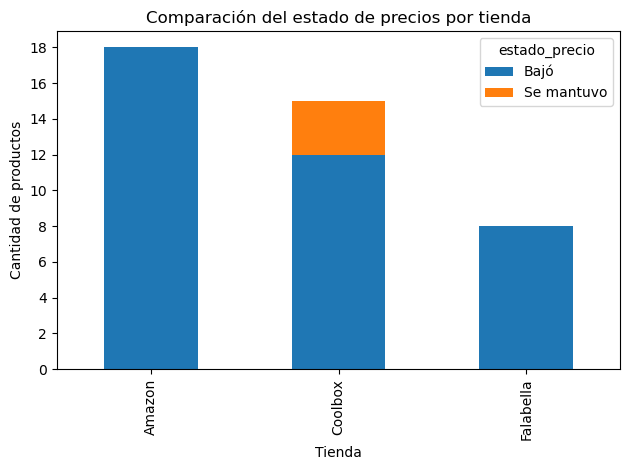

In [7]:
# Visualización: Estado de precios por tienda
from matplotlib.ticker import MaxNLocator

df_union.groupby("tienda")["estado_precio"].value_counts().unstack().plot(
    kind="bar",
    stacked=True,
    title="Comparación del estado de precios por tienda"
)

plt.xlabel("Tienda")
plt.ylabel("Cantidad de productos")

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [28]:
# Análisis de conveniencia por tienda
print("\n Análisis de conveniencia por tienda:")

resumen_tienda = (
    df_union
    .groupby(["tienda", "estado_precio"])
    .size()
    .unstack(fill_value=0)
)

print(resumen_tienda)

# Crear una métrica simple de conveniencia
resumen_tienda["indice_conveniencia"] = (
    resumen_tienda.get("Bajó", 0) - resumen_tienda.get("Subió", 0)
)

print("\n Índice de conveniencia por tienda:")
print(resumen_tienda["indice_conveniencia"].sort_values(ascending=False))



 Análisis de conveniencia por tienda:
estado_precio  Bajó  Se mantuvo
tienda                         
Amazon           18           0
Coolbox          12           3
Falabella         8           0

 Índice de conveniencia por tienda:
tienda
Amazon       18
Coolbox      12
Falabella     8
Name: indice_conveniencia, dtype: int64


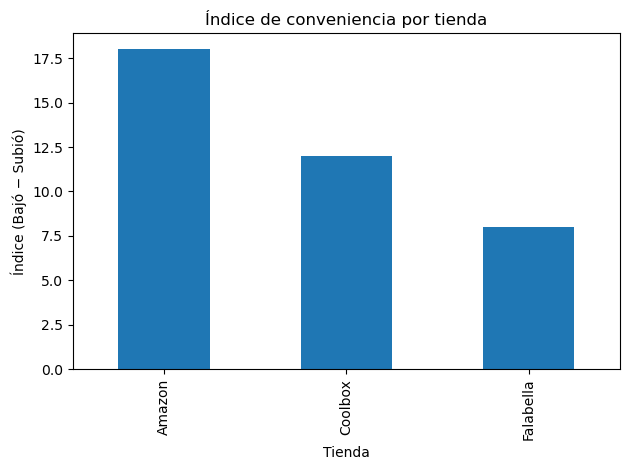

In [29]:
# # Visualización del índice de conveniencia por tienda 
resumen_tienda["indice_conveniencia"].plot(
    kind="bar",
    title="Índice de conveniencia por tienda"
)
plt.xlabel("Tienda")
plt.ylabel("Índice (Bajó − Subió)")
plt.tight_layout()
plt.show()
